## Attentions

To set up, untar the archives in the `saliency` directory.  You only need a few basic libraries to run this:

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import PIL.Image
import os

## Discriminator Attentions

To change the image for which saliency maps are shown, change the `img_index` to a value 0-9.

In [2]:
base_disc_dir = "saliency-disc-2000-v2/"
imgs = os.listdir(base_disc_dir)

# Change me!
img_index = 7

img_name = imgs[img_index]

In [3]:
with open(f"{base_disc_dir}{img_name}/image.npy", "rb") as f:
    im = np.load(f)
    
with open(f"{base_disc_dir}{img_name}/mask.npy", "rb") as f:
    heat = np.load(f)

### Original image

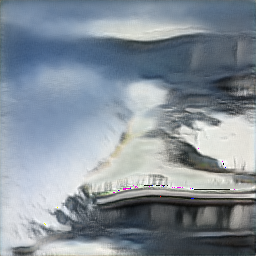

In [4]:
im = np.transpose((im * 255).round().astype(np.uint8)[0], (1, 2, 0))
heat = heat * (1 / heat.max())
heat = np.transpose((heat * 255).round().astype(np.uint8)[0], (1, 2, 0))
heatmap_img = cv2.applyColorMap(heat, cv2.COLORMAP_JET)

PIL.Image.fromarray(im)

### Saliency map overlay

You can change the mix factor below

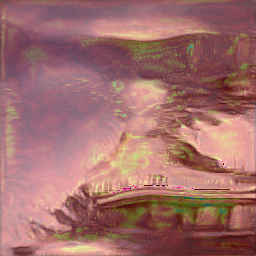

In [5]:
fin = cv2.addWeighted(heatmap_img, 0.3, im, 0.7, 0)
PIL.Image.fromarray(fin)

## Audio saliency

In [6]:
import scipy.constants as const
import scipy
from scipy.io import wavfile
from IPython.core.display import HTML

### Setup

like before, change the `img_index` variable below to change the audio file that is shown

In [7]:
base_audio_dir = "saliency-audio-e2e-2000/"
imgs = os.listdir(base_audio_dir)

# Change me!
img_index = 4

img_name = imgs[img_index]

In [8]:
with open(f"{base_audio_dir}{img_name}/image.npy", "rb") as f:
    im = np.load(f)
    
with open(f"{base_audio_dir}{img_name}/mask.npy", "rb") as f:
    heat = np.load(f)
    
im = np.transpose((im * 255).round().astype(np.uint8)[0], (1, 2, 0))
heat = heat * (1 / heat.max())

In [9]:
def wavPlayer(filepath):
    """ will display html 5 player for compatible browser

    Parameters :
    ------------
    filepath : relative filepath with respect to the notebook directory ( where the .ipynb are not cwd)
               of the file to play

    The browser need to know how to play wav through html5.

    there is no autoplay to prevent file playing when the browser opens
    """
    
    src = """
    <head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <title>Simple Test</title>
    </head>
    
    <body>
    <audio controls="controls" style="width:600px" >
      <source src="files/%s" type="audio/wav" />
      Your browser does not support the audio element.
    </audio>
    </body>
    """%(filepath)
    display(HTML(src))

### Audio file
You can listen to the audio file here.

In [10]:
wavPlayer(f"{base_audio_dir}{img_name}/{img_name}.wav")

## Plotting audio saliency

In [11]:
from scipy.io import wavfile
from matplotlib import pyplot as plt

sr, audio = wavfile.read(f"{base_audio_dir}{img_name}/{img_name}.wav")

you can change the number of bins here, if you want.  I found it necessary to downsample

In [12]:
bins = 2000
xs = list(range(0, audio.shape[0], bins))
heat_reduce = np.array([heat[:, xs[i]:xs[i + 1]].mean() for i in range(len(xs) - 1)])

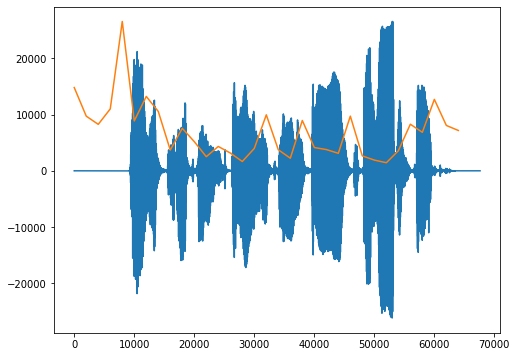

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(audio)
ax.plot(xs[:-1], heat_reduce * audio.max() / heat_reduce.max())

## Text saliency

first, grab a T5 tokenizer:

In [14]:
from transformers import T5Tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")

you can change `img_index` here:

In [15]:
base_text_dir = "saliency-text-e2e-2000/"
imgs = os.listdir(base_text_dir)

img_index = 6
img_name = imgs[img_index]

In [16]:
with open(f"{base_text_dir}{img_name}/image.npy", "rb") as f:
    im = np.load(f)
    
with open(f"{base_text_dir}{img_name}/mask.npy", "rb") as f:
    heat = np.load(f)
    
with open(f"{base_text_dir}{img_name}/caption.txt", "r") as f:
    caption = f.read().rstrip()

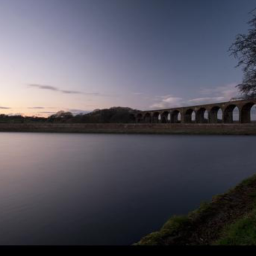

In [17]:
im = np.transpose((im * 255).round().astype(np.uint8)[0], (1, 2, 0))
PIL.Image.fromarray(im)

In [18]:
caption

'picture is a bridge runs along a body of water to the right is a tree with no leaves on a hill'

In [19]:
tokens = tokenizer.tokenize(caption)

heat_norm = heat[0, :len(tokens)]
heat_norm = (heat_norm - heat_norm.mean()) / heat_norm.std()

token_heat = {tokens[i]: heat_norm[i] for i in range(len(tokens))}
top_5 = [x for x in sorted(list(token_heat.items()), key=lambda t: t[1], reverse=True) if len(x[0]) > 3][:5]

In [20]:
print("Top 5 words by salience:")
for word, score in top_5:
    s = "%.2f" % score
    print(f"- {word}: {s}")

Top 5 words by salience:
- ▁water: 1.83
- ▁the: 1.13
- ▁bridge: 0.51
- ▁right: -0.01
- ▁leaves: -0.39
